In [1]:
#!pip install statsmodels==0.12.2

In [39]:
from numpy.testing import assert_equal, assert_almost_equal

# HW1: Forecasting Electricity Demand

In this homework, you will be forecasting the daily electricity demand for the entire Luzon grid.

Specifically, your goal is to build a <u>7-day ahead forecaster</u> using an ARIMA model.

<div class="alert alert-info">

**Important Note**
    
Make sure that you are running `statsmodels 0.12.2` when answering this homework.
</div>

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Set figure size
plt.rcParams["figure.figsize"] = (15,5)

df = pd.read_csv('elecdaily_luzon.csv', index_col=0)
df.index = pd.to_datetime(df.index)

# My personal preference is to use the pandas.Series, but you can use a pandas.DataFrame as well.
ts = df['GW']
ts

2019-01-01    121.10
2019-01-02    151.82
2019-01-03    175.55
2019-01-04    180.56
2019-01-05    173.11
               ...  
2019-12-27    185.00
2019-12-28    179.62
2019-12-29    175.00
2019-12-30    162.19
2019-12-31    151.71
Name: GW, Length: 365, dtype: float64

In [41]:
import warnings

warnings.filterwarnings("ignore")

## Q1.

Plot the series together with its ACF plot. 

Comment on the seasonality of the time series and its other interesting characteristics.

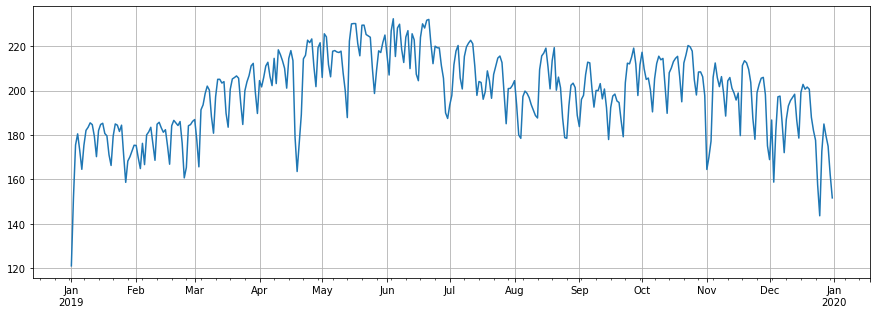

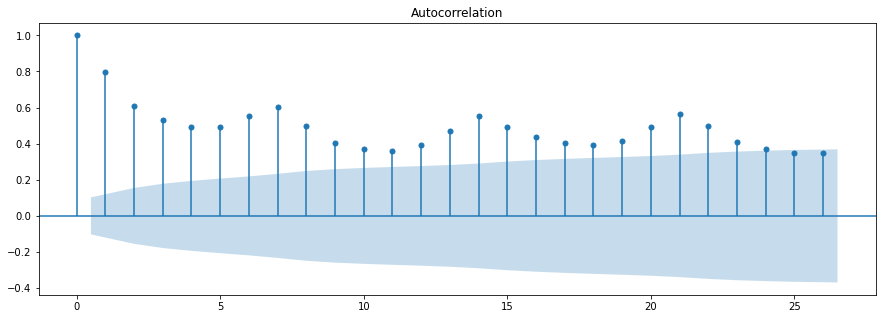

In [42]:
# YOUR CODE HERE
ax = ts.plot()
ax.grid('on', which = 'major')
ax.autoscale()
plt.show()

plot_acf(ts)
plt.show()

The ACF shows large and positive autocorrelations and also decreases slowly, implying a trend. It also appears to show seasonality as the ACF plot peaks at every 7th lag.  

As such, the data **seems** to be non-stationary as its ACF displays what seems to be trend-like and seasonality-like behavior. 

When looking into monthly behavior, the electricity usage seems to be higher in the summer months, which is intuitive, as it is when the the summer season causes higher temperatures in the Philippines. I find it interesting that there are sharp drops in the demand for electricity in the middle of April and the start of November.

## Q2.

Verify that the series is NOT stationary using an ADF test.

Fill in the `adf_stat` variable.

In [43]:
adf_stat = None

# YOUR CODE HERE

def adf_test(ts):
    res = adfuller(ts)
    print('ADF = %f' % res[0])
    print('p-value = %f' % res[1])
    print('Critical Values:')
    for k, v in res[4].items():
        print('\t%s: %.3f' % (k, v))
    return res

adf_result = adf_test(ts)
adf_stat = adf_result[0]

ADF = -1.343763
p-value = 0.608921
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


As the absolute value of the ADF is less than the critical value at 5% and the p-value is greater than 0.05, we do not reject the null hypothesis of the ADF test. Therefore, this series is **not stationary**.

In [44]:
# Sanity check
assert adf_stat is not None, 'Put the ADF statistic in this variable!'

# Hidden tests

## Q3. 

Apply the appropriate seasonal differencing to make the series stationary. Verify using an ADF test.

Fill in the `m` and `adf_stat` variables.

In [45]:
m = None
adf_stat = None

# YOUR CODE HERE
m = 7
ts_diff = ts.diff(7)[7:]

adf_result = adf_test(ts_diff)
adf_stat = adf_result[0]

ADF = -5.220284
p-value = 0.000008
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


As the absolute value of the ADF is greater than the critical value at 5% and the p-value is lesser than 0.05, we  reject the null hypothesis of the ADF test. Therefore, this series is now **stationary**.

In [46]:
# Sanity check
assert m is not None, 'Put the differencing parameter in this variable!'

# Hidden tests

In [47]:
# Sanity check
assert adf_stat is not None, 'Put the ADF statistic in this variable!'

# Hidden tests

## Interlude

Recall that your goal is to build a <u>7-day ahead forecaster</u>.

First, we'll hold out the last 84 observations (approx. 3 months) to use as a test set.

In [53]:
h = 7
test_size = 84

ts_train = ts[:-test_size]
ts_test = ts[-test_size:]

## Q4.

Create a grid for the $(p,d,q)$ parameters.

Let,

- $p=0,1,2$


- $d=0,1$


- $q=0,1,2$

Fill in the `pdq_grid` variable.

In [ ]:
pdq_grid = None

# YOUR CODE HERE

p = range(3)
d = range(2)
q = range(3)
pdq_grid = list(itertools.product(p, d, q))

In [ ]:
# Sanity check
assert pdq_grid is not None, 'Put the (p,d,q) grid in this variable!'
assert type(pdq_grid) == list, 'pdq_grid should be a list of tuples!'
assert all(isinstance(_, tuple) for _ in pdq_grid), 'pdq_grid should be a list of tuples!'

# Hidden tests

## Q5.

Using the training set, use grid search with a 4-fold time series split (validation size of 28) to select the best $(p,d,q)$ by minimizing the average RMSE,

$$\text{RMSE} = \sqrt{\frac{1}{n}\sum_i^n (y_i - \hat{y}_i)^2}$$

For each $(p,d,q)$, place its average RMSE score in `df_results`. Make sure to follow the pre-set structure of `df_results`.

In addition, fill in the `tskfold` variable.

Finally, use the following settings when fitting the ARIMA model:

1. `ARIMA(..., enforce_stationarity=False, enforce_invertibility=False)`


2. `.fit(method_kwargs={'maxiter': 200})`


The first condition will supress warnings about parameter combinations that result in non-stationary/non-invertible models. You can read about the technical details [`here`](https://otexts.com/fpp3/AR.html) and [`here`](https://otexts.com/fpp3/MA.html) .

The second condition will fix the MLE convergence warnings.

In [56]:
df_results = pd.DataFrame({'(p,d,q)': pdq_grid, 'Avg. RMSE': np.zeros(len(pdq_grid))})
df_results

,"(p,d,q)",Avg. RMSE
0,"(0, 0, 0)",0.0
1,"(0, 0, 1)",0.0
2,"(0, 0, 2)",0.0
3,"(0, 1, 0)",0.0
4,"(0, 1, 1)",0.0
5,"(0, 1, 2)",0.0
6,"(1, 0, 0)",0.0
7,"(1, 0, 1)",0.0
8,"(1, 0, 2)",0.0
9,"(1, 1, 0)",0.0


In [57]:
tskfold = TimeSeriesSplit(n_splits=4, test_size=h)

for train_index, val_index in tskfold.split(ts_train):
    print("Val Index:", val_index)

Val Index: [253 254 255 256 257 258 259]
Val Index: [260 261 262 263 264 265 266]
Val Index: [267 268 269 270 271 272 273]
Val Index: [274 275 276 277 278 279 280]


In [59]:
avg_rmse = []
y_pred_list = []
m = 7
h = 7

for pdq in pdq_grid:
    print(pdq)
    rmse =[]
    for train_index, val_index in tskfold.split(ts_train):
        x_train = ts_train[train_index]
        y_val = ts_train[val_index]
        
        x_train_diff = (x_train).diff(m)[m:]
        
        model = ARIMA(x_train_diff,
                      order=pdq, 
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit(method_kwargs={'maxiter': 200})
        
        y_pred = model.forecast(h)
        
        if -m+h ==0:
            y_pred_true = (x_train[-m:]).to_numpy() + y_pred
        else:
            y_pred_true = (x_train[-m:-m + h]).to_numpy() + y_pred
        
        y_pred_list.append(y_pred)
        
        rmse.append(mean_squared_error(y_val, y_pred_true)**(1/2))
        
    avg_rmse.append(np.mean(rmse))

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)


In [60]:
tskfold

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=7)

In [61]:
df_results['Avg. RMSE'] = avg_rmse
df_results

,"(p,d,q)",Avg. RMSE
0,"(0, 0, 0)",11.612866
1,"(0, 0, 1)",11.483244
2,"(0, 0, 2)",11.432567
3,"(0, 1, 0)",10.554101
4,"(0, 1, 1)",10.484644
5,"(0, 1, 2)",11.621263
6,"(1, 0, 0)",10.830959
7,"(1, 0, 1)",10.971241
8,"(1, 0, 2)",10.953791
9,"(1, 1, 0)",10.443725


In [62]:
len(avg_rmse)

18

In [63]:
# Sanity check
assert type(tskfold) == TimeSeriesSplit, 'tskfold should be a TimeSeriesSplit object!'
assert df_results['(p,d,q)'].tolist() == pdq_grid, 'df_results appears to be out of order. Do not sort it.'
assert all(isinstance(_, float) for _ in df_results['Avg. RMSE']), 'df_results should contain floats!'

# Hidden tests (Checks Avg. RMSE up to 3 decimal places)

## Q6.

Using the best $(p,d,q)$, evaluate its performance on the test set using cross-validation. 

This time, use a 12-fold time series split and calculate the average RMSE.

*Note: 12-folds * 7-steps = 84 observations which is the test size!*

Fill in the `p`, `d`, `q`, and `test_error` variables.

In [64]:
tskfold = TimeSeriesSplit(n_splits=12, test_size=7)

In [65]:
p = 2
d = 0
q = 2

mse = []
for train_index, val_index in tskfold.split(ts):

    # train-val split
    x_train = ts[train_index]
    y_val = ts[val_index]

    # log, s.diff
    x_d = x_train.diff(m)[m:] 

    # fit ARIMA
    model = ARIMA(x_d, order=(2,0,2), enforce_stationarity=False,
                  enforce_invertibility=False).fit(method_kwargs=
                                                   {'maxiter': 200})

    # forecast
    y_pred = model.forecast(h)

    # reverse log, s.diff
    if -m+h == 0:
        y_pred = x_train[-m:].to_numpy() + y_pred.to_numpy()
    else:
        y_pred = x_train[-m:-m+h].to_numpy() + y_pred.to_numpy()

    y_pred_list.append(y_pred)
    # compile error
    mse.append((mean_squared_error(y_val, y_pred))**(1/2))

test_error = np.mean(mse)

print('Test Avg. RMSE =', test_error)

Test Avg. RMSE = 11.93090112337836


In [71]:
test_error

11.93090112337836

In [66]:
# Sanity check
assert p is not None, 'Put the best p in this variable!'
assert d is not None, 'Put the best d in this variable!'
assert q is not None, 'Put the best q in this variable!'
assert test_error is not None, 'Put the average RMSE in this variable!'

# Hidden tests (Checks Avg. RMSE up to 3 decimal places)

## Q7.

Evaluate the performance of a naive and seasonal naive baseline on the test set, following the same strategy as above.

Fill in the `test_error_naive` and `test_error_snaive` variables.

In [67]:
mse = []
errors = {'ARIMA': [], 'S.Naive': [], 'Naive':[]}
for train_index, val_index in tskfold.split(ts):

    # train-val split
    x_train = ts[train_index]
    y_val = ts[val_index]

    # log, s.diff
    x_d = x_train.diff(m)[m:] 

    # fit ARIMA
    model = ARIMA(x_d, order=(2,0,2), enforce_stationarity=False,
                  enforce_invertibility=False).fit(method_kwargs=
                                                   {'maxiter': 200})

    # forecast
    y_pred = model.forecast(h)

    # reverse log, s.diff
    if -m+h == 0:
        y_pred = x_train[-m:].to_numpy() + y_pred.to_numpy()
    else:
        y_pred = x_train[-m:-m+h].to_numpy() + y_pred.to_numpy()

    y_pred_list.append(y_pred)
    # compile error
    mse.append((mean_squared_error(y_val, y_pred))**(1/2))
    errors['ARIMA'].append(mean_squared_error(y_val, y_pred)**(1/2))
    errors['S.Naive'].append(mean_squared_error(y_val, x_train[-m:])**(1/2))
    errors['Naive'].append(mean_squared_error(y_val, np.repeat(x_train[-1],7))**(1/2))

In [68]:
test_error_naive = None
test_error_snaive = None

# YOUR CODE HERE
test_error_naive = np.mean(errors['Naive'])
test_error_snaive = np.mean(errors['S.Naive'])

print('  Naive Avg. RMSE =', test_error_naive)
print('S.Naive Avg. RMSE =', test_error_snaive)

  Naive Avg. RMSE = 16.256868939932897
S.Naive Avg. RMSE = 13.899161539446638


In [69]:
# Sanity check
assert test_error_naive is not None, 'Put the average RMSE for the Naive method in this variable!'

# Hidden tests (Checks Avg. RMSE up to 3 decimal places)

In [70]:
# Sanity check
assert test_error_snaive is not None, 'Put the average RMSE for the S.Naive method in this variable!'

# Hidden tests (Checks Avg. RMSE up to 3 decimal places)